GPU

In [ ]:
!nvidia-smi

Mon Sep 18 10:37:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importing Libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm.auto import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import cv2
from skimage.io import imread, imshow, show

from tensorflow import keras
from keras import layers
from keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed = seed  # To get same random seed everytime we run the whole thing.
random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

## Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [ ]:
H1_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H1/*"
H2_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H2/*"
H3_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H3/*"
H5_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H5/*"
H6_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H6/*"

In [ ]:
def sorted_file_paths(path):
    file_paths = sorted(glob(path))
    print("Total image files:")
    print(f"{len(file_paths)} \n")
    return file_paths

H1_file_paths = sorted_file_paths(H1_path)
H2_file_paths = sorted_file_paths(H2_path)
H3_file_paths = sorted_file_paths(H3_path)
H5_file_paths = sorted_file_paths(H5_path)
H6_file_paths = sorted_file_paths(H6_path)

Total image files:
4357 

Total image files:
2314 

Total image files:
816 

Total image files:
814 

Total image files:
739 



In [ ]:
all_file_paths = H1_file_paths + H2_file_paths + H3_file_paths + H5_file_paths + H6_file_paths
print(len(all_file_paths))
print(4357+2314+816+814+739)

9040
9040


In [ ]:
def image_preprocess(paths):
    total = len(paths)
    im_array = np.zeros((total, 128, 128, 3), dtype = np.float32)
    for i in tqdm(range(total)):
        img = imread(paths[i])  # Numpy Array = (500,500,3)
        # print(image.shape)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        im_array[i, :,:,:] = img
    return im_array

# X = image_preprocess(all_file_paths)
X = np.load("/content/drive/MyDrive/ICCIT 2023/npy_files/array_9040.npy")
print(X.shape)
print(X.dtype)

(9040, 128, 128, 3)
float32


In [ ]:

# np.save("/content/drive/MyDrive/ICCIT 2023/npy_files/array_9040.npy", X)

In [ ]:
labels = ['H1']*4357 + ['H2']*2314 + ['H3']*816 + ['H5']*814 + ['H6']*739
print(type(labels))
print(len(labels))
# print(labels[3300])
# print(labels)

<class 'list'>
9040


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(labels)
print(y.shape)
print(y)
print('\n')


classes = list(label_enconder.classes_)
print(classes)
print('\n')

(9040,)
[0 0 0 ... 4 4 4]


['H1', 'H2', 'H3', 'H5', 'H6']




In [ ]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(X.dtype, y.dtype)
# All are 4D and 1D array.

(9040, 128, 128, 3) (9040,)
float32 float32


## Model creation

In [ ]:
input_shape = (128, 128, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [ ]:
def create_vit_classifier(layer):
    input_shape = (128, 128, 3)
    num_classes = 5

    inputs = layers.Input(shape=input_shape)

    augmented = layer(inputs)

    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes, activation='softmax')(features)

    model = keras.Model(inputs=inputs, outputs=logits)

    return model


In [ ]:
model = create_vit_classifier(data_augmentation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches[0][0]']         

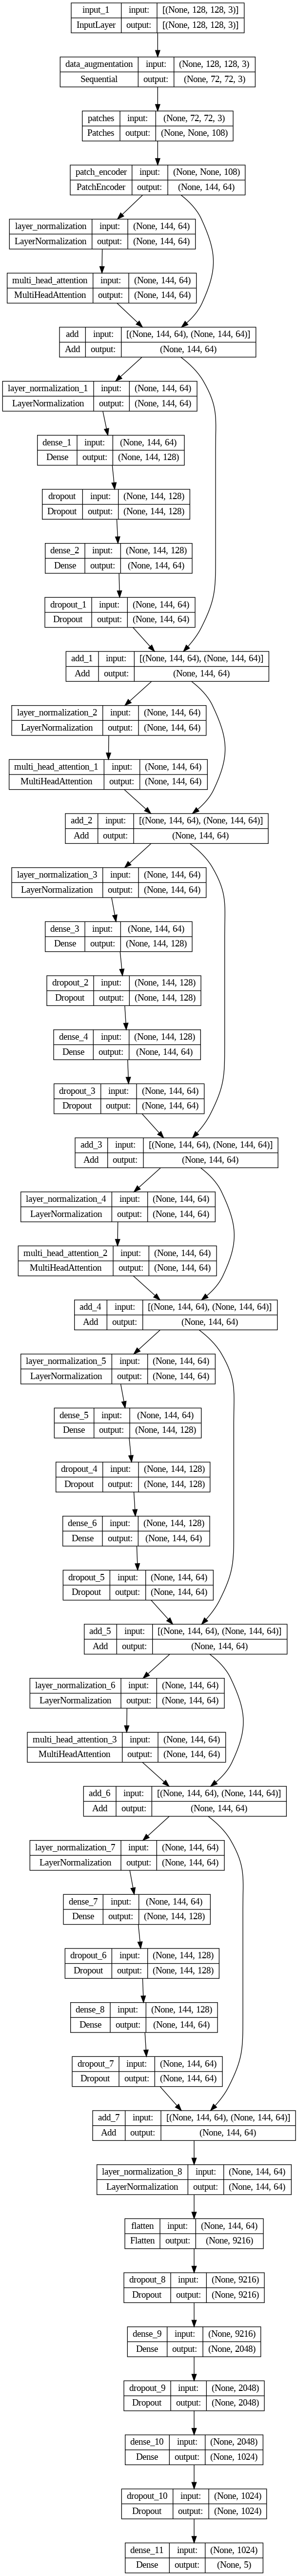

In [ ]:

tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
def metric_calculation(true, out):

    f1_metric = tf.keras.metrics.F1Score()
    f1_metric.update_state(true, out)
    f1_scores = f1_metric.result().numpy()
    f1 = np.mean(f1_scores)

    pred = np.zeros((true.shape[0],5))
    for i in range(true.shape[0]):
        indx = np.argmax(out[i,:])
        pred[i,indx] = 1

    recall_scores = []
    pre_scores =[]
    for i in range(5):
        re_metric = tf.keras.metrics.Recall()
        pre_metric = tf.keras.metrics.Precision()
        re_metric.update_state(true[:,i],pred[:,i])
        pre_metric.update_state(true[:,i],pred[:,i])

        recall_scores.append(re_metric.result().numpy())
        pre_scores.append(pre_metric.result().numpy())

    recall = np.mean(np.array(recall_scores))
    precision = np.mean(np.array(pre_scores))

    return precision, recall, f1

In [ ]:
# xx = np.array([[1, 0, 0],
#                [1, 0, 0],
#                [0, 1, 0],
#                [0, 0, 1]])
# yy = np.array([[0.9, 0.05, 0.05],
#                [0.1, 0.8, 0.1],
#                [0.2, 0.7, 0.1],
#                [0.2, 0.2, 0.6]])
# a, b, c = metric_calculation(xx, yy)
# print(a, b, c)

In [21]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
history_all = []
f1_all = []
pre_all = []
rec_all = []

for train, test in cv.split(X, y):

    print('   ')
    print(f'Training for fold {fold_no} ...', '\n')

    x_train = X[train]
    x_test = X[test]
    y_train = y[train]
    y_test = y[test]

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

    data_augmentation = keras.Sequential([layers.Normalization(),
                                          layers.Resizing(image_size, image_size),
                                          layers.RandomFlip("horizontal"),
                                          layers.RandomRotation(factor=0.02),
                                          layers.RandomZoom(height_factor=0.2, width_factor=0.2)],
                                          name="data_augmentation")


    data_augmentation.layers[0].adapt(x_train)

    model = create_vit_classifier(data_augmentation)

    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
                                     weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])


    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_test, y_test))

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%", '\n')

    prediction = model.predict(x_test)
    pre, rec, f1 = metric_calculation(y_test, prediction)

    print(f"F1 Score: {round(f1 * 100, 2)}%", '\n')
    print(f"Precision: {round(pre * 100, 2)}%", '\n')
    print(f"Recall: {round(rec * 100, 2)}%", '\n')

    acc_per_fold.append(accuracy*100)
    f1_all.append(f1)
    pre_all.append(pre)
    rec_all.append(rec)
    history_all.append(history)

    fold_no = fold_no + 1

    if fold_no == 3: break


   
Training for fold 1 ... 

Epoch 1/100
226/226 [==============================] - 11s 25ms/step - loss: 1.8359 - accuracy: 0.5058 - val_loss: 0.9478 - val_accuracy: 0.6128
Epoch 2/100
226/226 [==============================] - 4s 19ms/step - loss: 0.9768 - accuracy: 0.6066 - val_loss: 0.8829 - val_accuracy: 0.6482
Epoch 3/100
226/226 [==============================] - 4s 19ms/step - loss: 0.9257 - accuracy: 0.6264 - val_loss: 0.7927 - val_accuracy: 0.6781
Epoch 4/100
226/226 [==============================] - 4s 19ms/step - loss: 0.8679 - accuracy: 0.6507 - val_loss: 0.7841 - val_accuracy: 0.7008
Epoch 5/100
226/226 [==============================] - 4s 19ms/step - loss: 0.8478 - accuracy: 0.6567 - val_loss: 0.7905 - val_accuracy: 0.6698
Epoch 6/100
226/226 [==============================] - 4s 19ms/step - loss: 0.8303 - accuracy: 0.6699 - val_loss: 0.7908 - val_accuracy: 0.6858
Epoch 7/100
226/226 [==============================] - 4s 19ms/step - loss: 0.7997 - accuracy: 0.6727 - v

## Data Retrieve

In [28]:
print(y_test.shape)
print(prediction.shape)

y_pred = np.zeros((y_test.shape[0],5))
for i in range(y_test.shape[0]):
      indx = np.argmax(prediction[i,:])
      y_pred[i,indx] = 1

correct = 0
for i in range(y_pred.shape[0]):
    if np.sum(y_test[i,:]==y_pred[i,:]) == 5:
        correct = correct + 1
accuracy = correct / y_test.shape[0]
print(accuracy*100)

truelabel = []
predlabel = []

for i in range(y_test.shape[0]):
    if y_test[i, 0] == 1:
        truelabel.append("H1")
    if y_test[i, 1] == 1:
        truelabel.append("H2")
    if y_test[i, 2] == 1:
        truelabel.append("H3")
    if y_test[i, 3] == 1:
        truelabel.append("H5")
    if y_test[i, 4] == 1:
        truelabel.append("H6")
truelabel = np.array(truelabel)

for i in range(y_pred.shape[0]):
    if y_pred[i, 0] == 1:
        predlabel.append("H1")
    if y_pred[i, 1] == 1:
        predlabel.append("H2")
    if y_pred[i, 2] == 1:
        predlabel.append("H3")
    if y_pred[i, 3] == 1:
        predlabel.append("H5")
    if y_pred[i, 4] == 1:
        predlabel.append("H6")

truelabel = np.array(truelabel)
predlabel = np.array(predlabel)

temp = 0
for i in range(truelabel.shape[0]):
    if truelabel[i] == predlabel[i]: temp = temp + 1
print(temp*100/truelabel.shape[0])

(1808, 5)
(1808, 5)
81.91371681415929
81.91371681415929


In [29]:
np.save('/content/drive/MyDrive/ICCIT 2023/Test Result and Model/ViT_full_truelabel.npy', truelabel)
np.save('/content/drive/MyDrive/ICCIT 2023/Test Result and Model/ViT_full_predlabel.npy', predlabel)

## History an File Saving to Numpy Array

In [ ]:
history_nparray = np.zeros((20, 100))
print(len(history_all[0].history))

count = 0

for k in tqdm(range(5)):

    aa = history_all[k].history      # Dictionary

    history_nparray[count, :] = np.array(aa['loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['accuracy'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_accuracy'])
    count = count+1

print(count)
print(history_nparray[-1,:])

4


  0%|          | 0/5 [00:00<?, ?it/s]

20
[0.59623891 0.64269912 0.6863938  0.69358408 0.67975664 0.63827431
 0.69081861 0.71460176 0.71736723 0.70741153 0.70077431 0.72013277
 0.71626109 0.72123891 0.72234511 0.75553095 0.74778759 0.72621679
 0.74115044 0.73949116 0.73396015 0.76659292 0.75884956 0.71681416
 0.75829649 0.75663716 0.75884956 0.75995576 0.77378321 0.7715708
 0.76106197 0.75995576 0.75553095 0.78373891 0.77710176 0.79037613
 0.78650445 0.77820796 0.78373891 0.78207964 0.79535401 0.77654868
 0.78097343 0.78539824 0.81305307 0.77654868 0.79756635 0.80475664
 0.79756635 0.80254424 0.80530971 0.7920354  0.7909292  0.80088496
 0.75663716 0.80088496 0.79922569 0.80475664 0.81581861 0.80254424
 0.79037613 0.81747788 0.81028759 0.8136062  0.79867256 0.8136062
 0.81803095 0.8113938  0.8125     0.81803095 0.81803095 0.80254424
 0.80365044 0.80918139 0.80696905 0.77876109 0.82300884 0.81084073
 0.81471241 0.8125     0.81526548 0.82024336 0.81471241 0.81637168
 0.78650445 0.8113938  0.82079649 0.81581861 0.82300884 0.808

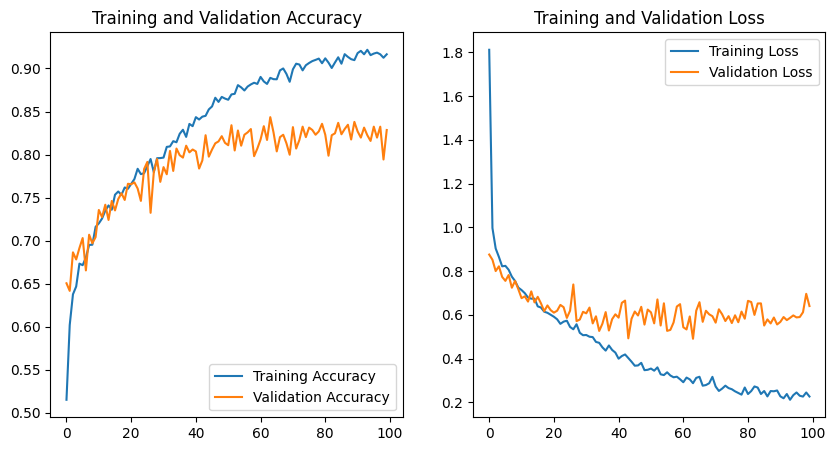

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(100), history_nparray[5,:], label='Training Accuracy')
plt.plot(range(100), history_nparray[7,:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), history_nparray[4,:], label='Training Loss')
plt.plot(range(100), history_nparray[6,:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
np.save('/content/ViT_9040_History.npy', history_nparray)

acc_f1_pre_rec = np.zeros((4,5))
acc_f1_pre_rec[0,:] = np.array(acc_per_fold)
acc_f1_pre_rec[1,:] = np.array(f1_all)
acc_f1_pre_rec[2,:] = np.array(pre_all)
acc_f1_pre_rec[3,:] = np.array(rec_all)

np.save('/content/ViT_9040_Acc_F1_Pre_Rec.npy', acc_f1_pre_rec)